In [ ]:
import h5py
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

def downsize_and_split(
    input_files: list, output_dir: str, train_size: int, val_size: int, test_size: int
):
    """
    Combine multiple HDF5 files, shuffle, and downsample to create train/val/test splits.

    :param input_files list: List of input HDF5 file paths
    :param output_dir str: Output directory (should exist, no subdirs needed)
    :param train_size int: Number of training samples
    :param val_size int: Number of validation samples
    :param test_size int: Number of test samples
    """

    # First, collect all datasets from all files
    all_data = {}
    total_samples = 0

    # Get all keys from the first file
    with h5py.File(input_files[0], "r") as f:
        keys = list(f.keys())

    # Concatenate data from all files
    for k in keys:
        all_data[k] = []

    for file in input_files:
        with h5py.File(file, "r") as f:
            n = len(f[keys[0]])
            total_samples += n
            for k in keys:
                all_data[k].append(f[k][...])

    # Stack data for each key
    for k in keys:
        all_data[k] = np.concatenate(all_data[k], axis=0)

    # Shuffle indices and downsample
    total = len(all_data[keys[0]])
    assert train_size + val_size + test_size <= total, "Requested more samples than available"
    indices = np.random.permutation(total)[: train_size + val_size + test_size]

    train_indices = np.sort(indices[:train_size])
    val_indices = np.sort(indices[train_size : train_size + val_size])
    test_indices = np.sort(indices[train_size + val_size :])

    path = Path(output_dir).resolve()

    def write_split(split_name, split_indices, split_size):
        if split_size > 0:
            (path / split_name).mkdir(parents=True, exist_ok=True)
            with h5py.File(str(path / split_name / f"{split_name}.hdf5"), "w-") as g:
                for k in keys:
                    g.create_dataset(k, (split_size, *all_data[k].shape[1:]))
                for ii, jj in enumerate(tqdm(split_indices, desc=f"Writing {split_name}")):
                    for k in keys:
                        g[k][ii, ...] = all_data[k][jj, ...]

    write_split("train", train_indices, train_size)
    write_split("val", val_indices, val_size)
    write_split("test", test_indices, test_size)
# ...existing code...

In [13]:
import h5py

input_files = [
    # "../data/single_cubby/mixed/all_data.hdf5",
    # "../data/single_cubby/free/all_data.hdf5",
    "../data/single_cubby/task/all_data.hdf5"
]

# input_files = [
#     "../data/single_cubby_tasks/mixed/all_data.hdf5",
#     "../data/single_cubby_tasks/free/all_data.hdf5",
#     "../data/single_cubby_tasks/task/all_data.hdf5"
# ]

total_traj_num = 0

for input_file in input_files:
    with h5py.File(input_file, "r") as f:
        num_samples = len(f["cuboid_centers"])
        print(f"File: {input_file}")
        print(f"  Number of samples in the dataset: {num_samples}")
        # global_solutions = f["global_solutions"]
        # trajectory_length = global_solutions.shape[1]
        # print(f"  Trajectory length of global_solutions: {trajectory_length}\n")
        total_traj_num += num_samples

print(f"Total number of trajectories: {total_traj_num}")

File: ../data/single_cubby/task/all_data.hdf5
  Number of samples in the dataset: 4558
Total number of trajectories: 4558


In [23]:
input_file = input_files[0]  # Use the first file to read cuboid data
with h5py.File(input_file, "r") as f:
    cuboid_centers = f["cuboid_centers"][0]
    cuboid_dims = f["cuboid_dims"][0]
    cuboid_quaternions = f["cuboid_quaternions"][0]
    print("cuboid_centers[0]:", cuboid_centers)
    print("cuboid_dims[0]:", cuboid_dims)
    print("cuboid_quaternions[0]:", cuboid_quaternions)


cuboid_centers[0]: [[ 0.9    0.     0.35 ]
 [ 0.725  0.     0.2  ]
 [ 0.725  0.     0.7  ]
 [ 0.725 -0.7    0.45 ]
 [ 0.725  0.7    0.45 ]
 [ 0.725  0.     0.45 ]]
cuboid_dims[0]: [[0.02 1.4  0.7 ]
 [0.35 1.4  0.02]
 [0.35 1.4  0.02]
 [0.35 0.02 0.52]
 [0.35 0.02 0.52]
 [0.35 1.4  0.02]]
cuboid_quaternions[0]: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [14]:
input_files = [
    # "../data/single_cubby/mixed/all_data.hdf5",
    # "../data/single_cubby/free/all_data.hdf5",
    "../data/single_cubby/task/all_data.hdf5"
]

# input_files = [
#     "../data/single_cubby_tasks/mixed/all_data.hdf5",
#     "../data/single_cubby_tasks/free/all_data.hdf5",
#     "../data/single_cubby_tasks/task/all_data.hdf5"
# ]


downsize_and_split(input_files, 
                   output_dir="pretrain_data/single_cubby_pretrain_4k", 
                   train_size=4000, 
                   val_size=500, 
                   test_size=0)

Writing train:   0%|          | 0/4000 [00:00<?, ?it/s]

Writing val:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# Script to systematically sample HDF5 files 

import h5py
import numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm
import time

SRC_DIR = Path("pretrain_data/mpinets_hybrid_training_data")
DST_DIR = Path("pretrain_data/mpinets_hybrid_training_data_tiny")

def sample_hdf5_systematic(src_file, dst_file, fraction=0.03):
    """Optimized systematic sampling of HDF5 file (every nth item)"""
    start_time = time.time()
    
    with h5py.File(src_file, "r") as src:
        # Identify the main key (only once)
        main_key = next(k for k in src.keys() if src[k].ndim > 1)
        num_items = src[main_key].shape[0]
        
        # Calculate sampling step (every nth item)
        step = max(1, int(1 / fraction))
        sample_size = num_items // step
        
        print(f"Sampling {src_file}: {num_items:,} → {sample_size:,} items (every {step}th)")
        
        # Create destination file
        with h5py.File(dst_file, "w") as dst:
            for key in src.keys():
                data = src[key]
                if data.shape and data.shape[0] == num_items:
                    # Systematic sampling: read every nth item directly
                    sampled_data = data[::step]
                    
                    # Write with optimized settings
                    dst.create_dataset(key, 
                                     data=sampled_data,
                                     compression="gzip",
                                     chunks=True,
                                     shuffle=True)
                else:
                    # For small datasets that don't need sampling
                    dst.create_dataset(key, 
                                     data=data[()], 
                                     compression="gzip")

    print(f"Processed {src_file.name} in {time.time()-start_time:.2f} seconds")

if DST_DIR.exists():
    shutil.rmtree(DST_DIR)

for split in ["train", "val"]:
    src_split = SRC_DIR / split
    dst_split = DST_DIR / split
    dst_split.mkdir(parents=True, exist_ok=True)
    h5files = list(src_split.glob("*.hdf5"))
    
    for h5file in h5files:
        dst_h5file = dst_split / h5file.name
        sample_hdf5_systematic(h5file, dst_h5file, fraction=0.03)

Sampling pretrain_data/mpinets_hybrid_training_data/train/train.hdf5: 3,270,000 → 99,090 items (every 33th)
Processed train.hdf5 in 8.85 seconds
Sampling pretrain_data/mpinets_hybrid_training_data/val/val.hdf5: 22,500 → 681 items (every 33th)
Processed val.hdf5 in 0.06 seconds


In [1]:
# Test loading the data
from data_loader import DataModule

# Define parameters for the DataModule
data_dir = "pretrain_data/single_cubby_tasks_135k"  # Replace with the actual path to your data
trajectory_key = "global_solutions"  # Replace with the actual key in your dataset
# trajectory_key = "hybrid_solutions"  # Use hybrid solutions for MpiNet
num_robot_points = 2048
num_obstacle_points = 4096
num_target_points = 128  # This is not used in MpiNet, but required by the DataModule
random_scale = 0  # For MpiNet, it's 0.015 
batch_size = 1

# Initialize the DataModule
data_module = DataModule(
    data_dir=data_dir,
    trajectory_key=trajectory_key,
    num_robot_points=num_robot_points,
    num_obstacle_points=num_obstacle_points,
    num_target_points=num_target_points,
    random_scale=random_scale,
    batch_size=batch_size,
    train_mode="finetune_tasks",  # Use "finetune_tasks" for fine-tuning tasks
)

# Setup the DataModule
data_module.setup(stage="fit")

# Access the dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Check how many data points are in the train and validation sets
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")

# Show what keys are available in the dataset batch
# Get a batch and print its keys
batch = next(iter(train_loader))
print("Available keys in a batch:", list(batch.keys()))

Databases found: [PosixPath('pretrain_data/single_cubby_tasks_135k/train/train.hdf5')]
Databases found: [PosixPath('pretrain_data/single_cubby_tasks_135k/val/val.hdf5')]
Number of training samples: 135000
Number of validation samples: 5000
Available keys in a batch: ['target_position', 'target_quaternion', 'target_pose', 'target_configuration', 'configuration', 'cuboid_dims', 'cuboid_centers', 'cuboid_quats', 'cylinder_radii', 'cylinder_heights', 'cylinder_centers', 'cylinder_quats']


In [3]:
import os
import matplotlib.pyplot as plt

def visualize_point_cloud(point_cloud, save_path=None, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    robot_points = point_cloud[point_cloud[:, 3] == 0]
    obstacle_points = point_cloud[point_cloud[:, 3] == 1]
    target_points = point_cloud[point_cloud[:, 3] == 2]

    if len(robot_points) > 0:
        ax.scatter(robot_points[:, 0], robot_points[:, 1], robot_points[:, 2], c='b', s=1, label='Robot')
    if len(obstacle_points) > 0:
        ax.scatter(obstacle_points[:, 0], obstacle_points[:, 1], obstacle_points[:, 2], c='r', s=1, label='Obstacle')
    if len(target_points) > 0:
        ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2], c='g', s=10, label='Target')

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [6]:
# Plot point clouds observed in the training set
for i, batch in enumerate(train_loader):
    if i >= 10:  # Limit to first 5 samples for visualization
        break
    point_cloud = batch['xyz'][0].numpy()
    visualize_point_cloud(point_cloud, save_path=f"visualizations/train_sample_{i}.png", title=f"Train Sample {i}")

In [2]:
# Test loading the data
from data_loader import DataModule

# Define parameters for the DataModule
data_dir = "pretrain_data/single_cubby_tasks_135k"  # Replace with the actual path to your data
train_model = "finetune_tasks"

trajectory_key = "global_solutions"  # Replace with the actual key in your dataset

num_robot_points = 2048
num_obstacle_points = 0
num_target_points = 0  # This is not used in MpiNet, but required by the DataModule
random_scale = 0  # For MpiNet, it's 0.015 
batch_size = 1

# Initialize the DataModule
data_module = DataModule(
    data_dir=data_dir,
    trajectory_key=trajectory_key,
    num_robot_points=num_robot_points,
    num_obstacle_points=num_obstacle_points,
    num_target_points=num_target_points,
    train_mode=train_model,
    random_scale=random_scale,
    batch_size=batch_size,
)

# Setup the DataModule
data_module.setup(stage="fit")

# Access the dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Print the number of batches in the train and validation loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

Databases found: [PosixPath('pretrain_data/single_cubby_tasks_135k/train/train.hdf5')]
Databases found: [PosixPath('pretrain_data/single_cubby_tasks_135k/val/val.hdf5')]
Number of batches in train loader: 135000
Number of batches in validation loader: 5000


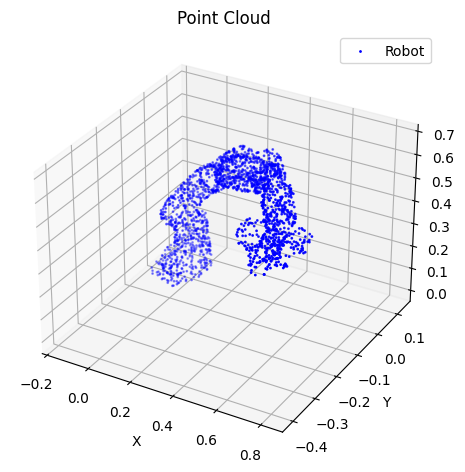

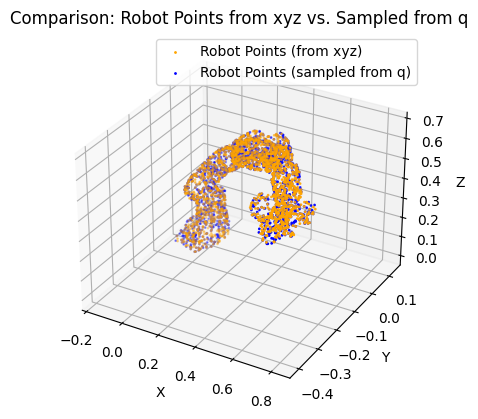

In [11]:
# Visualize the point cloud of the one sample in the train loader
batch = next(iter(train_loader))
point_cloud = batch['xyz'][0].numpy()
q = batch['configuration'][0].numpy()  # Assuming 'q' is the key for the point cloud data
visualize_point_cloud(point_cloud)

# Use q to sample the robot points and visualize them together with the original point cloud
import torch
from robofin.pointcloud.torch import FrankaSampler
import matplotlib.pyplot as plt

# Prepare q tensor
q_tensor = torch.as_tensor(q).float().unsqueeze(0)  # Shape: (1, 7) or (1, 8)
sampler = FrankaSampler("cpu", use_cache=True)
robot_points = sampler.sample(q_tensor, num_points=2048)[0].cpu().numpy()  # (2048, 3)

# Extract robot points from the original point cloud (label == 0)
robot_points_pc = point_cloud[point_cloud[:, 3] == 0][:, :3]

# Plot both sets of robot points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(robot_points_pc[:, 0], robot_points_pc[:, 1], robot_points_pc[:, 2], s=1, c='orange', label='Robot Points (from xyz)')
ax.scatter(robot_points[:, 0], robot_points[:, 1], robot_points[:, 2], s=1, c='b', label='Robot Points (sampled from q)')
ax.set_title("Comparison: Robot Points from xyz vs. Sampled from q")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [10]:
# Print the first 10 batches of target_configuration, configuration, and supervision
for i, batch in enumerate(train_loader):
    print(f"Batch {i + 1}:")
    
    print("Target Configuration:")
    print(batch["target_configuration"])
    
    print("Target Pose:")
    print(batch["target_pose"])
    
    print("\nConfiguration:")
    print(batch["configuration"])
    
    print("\nSupervision:")
    print(batch["supervision"])
    
    print("\n" + "-" * 50 + "\n")
    
    if i == 9:  # Stop after printing 10 batches
        break

Batch 1:
Target Configuration:
tensor([[ 0.3871,  0.4499, -1.0666, -2.2219,  2.2918,  1.7140, -1.5896]])
Target Pose:
tensor([[ 0.5969, -0.2558,  0.3117,  0.6992, -0.1057,  0.6992,  0.1057]])

Configuration:
tensor([[ 0.1860, -0.6172, -0.0542, -2.2172,  0.3987,  1.6161,  0.7911]])

Supervision:
tensor([[-0.0102,  0.0069, -0.0425, -0.0090,  0.0535,  0.0176, -0.0413]])

--------------------------------------------------

Batch 2:
Target Configuration:
tensor([[-1.0732,  0.5688,  1.1155, -2.4548, -0.4455,  2.3508, -2.2627]])
Target Pose:
tensor([[ 0.4101,  0.0810,  0.0892, -0.1139,  0.9706,  0.1631, -0.1357]])

Configuration:
tensor([[-0.3595,  1.4023,  1.1146, -1.3930, -0.5949,  2.3371, -2.4543]])

Supervision:
tensor([[-5.8568e-03, -6.8396e-03,  7.2718e-06, -8.7134e-03,  1.2259e-03,
          1.1277e-04,  1.5724e-03]])

--------------------------------------------------

Batch 3:
Target Configuration:
tensor([[ 0.0718, -0.5386,  0.2181, -2.3157,  0.2408,  1.7188,  0.8331]])
Target Pose:

Number of batches in train loader: 163500000
Number of batches in validation loader: 22500


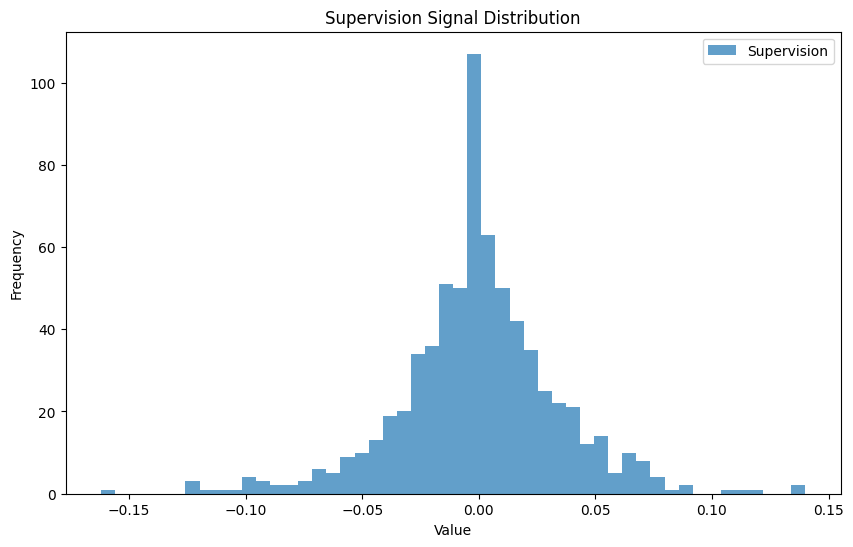

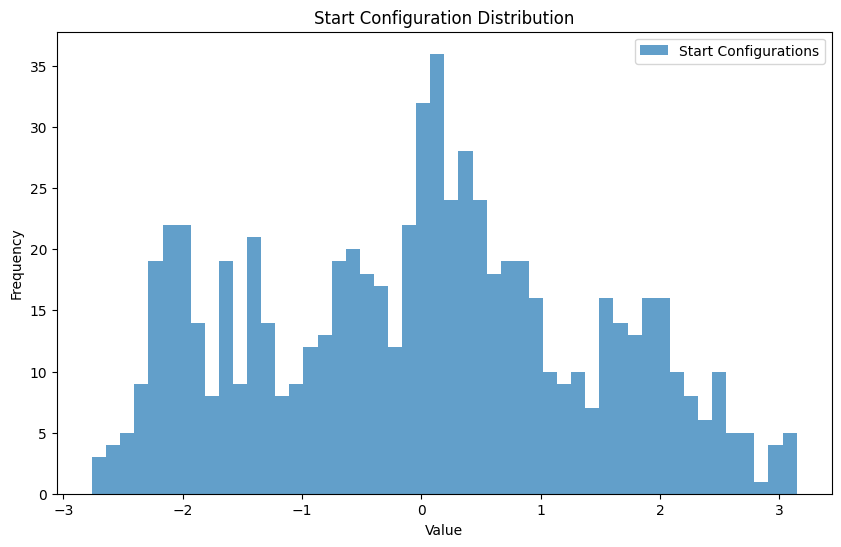

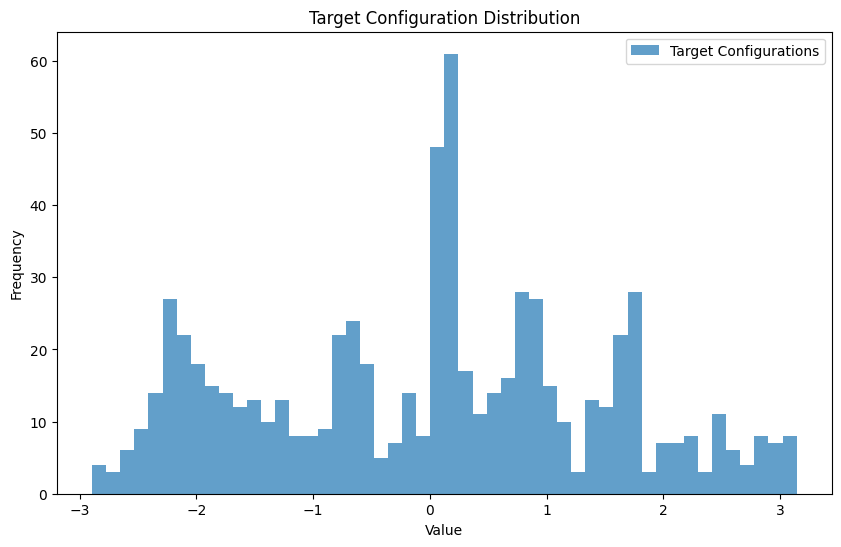

In [11]:
import torch
import numpy as np
# Check the number of batches in the train and validation loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")


import matplotlib.pyplot as plt

# Analyze supervision signal distribution with a subset of 50 batches
supervision_differences = []
start_configurations = []
target_configurations = []

# Limit to 50 batches
for i, batch in enumerate(train_loader):
    if i >= 100:
        break
    supervision_differences.append(batch["supervision"].numpy())
    start_configurations.append(batch["configuration"].numpy())
    target_configurations.append(batch["target_configuration"].numpy())

# Convert to numpy arrays
supervision_differences = np.concatenate(supervision_differences, axis=0)
start_configurations = np.concatenate(start_configurations, axis=0)
target_configurations = np.concatenate(target_configurations, axis=0)

# Plot supervision signal distribution
plt.figure(figsize=(10, 6))
plt.hist(supervision_differences.flatten(), bins=50, alpha=0.7, label="Supervision")
plt.title("Supervision Signal Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot start configuration distribution
plt.figure(figsize=(10, 6))
plt.hist(start_configurations.flatten(), bins=50, alpha=0.7, label="Start Configurations")
plt.title("Start Configuration Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot target configuration distribution
plt.figure(figsize=(10, 6))
plt.hist(target_configurations.flatten(), bins=50, alpha=0.7, label="Target Configurations")
plt.title("Target Configuration Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Target position statistics (sampled):
Shape: (42500, 3)
Min: [-0.5717391  -0.56236666  0.12572521]
Max: [0.571431  0.5602185 0.737114 ]
Mean: [ 0.00635508 -0.06963906  0.47240216]
Std: [0.30641764 0.29413837 0.16804391]
Range: [1.1431701 1.1225852 0.6113888]


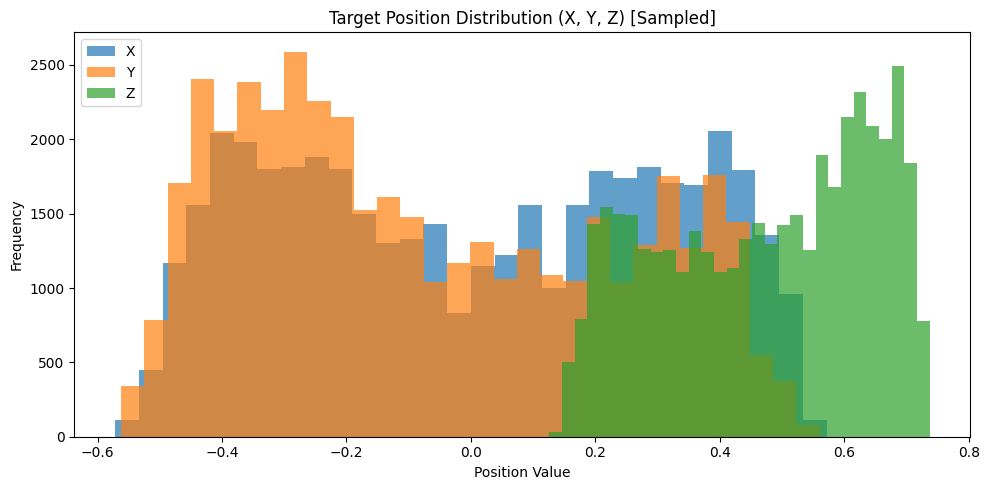

In [8]:
import numpy as np

# Sample a portion of the training set for target position statistics
target_positions = []
sample_portion = 0.1  # Use 10% of the batches
max_batches = int(len(train_loader) * sample_portion)
max_batches = max(1, max_batches)  # At least 1 batch

for i, batch in enumerate(train_loader):
    target_pose = batch["target_pose"]
    if target_pose.ndim == 2 and target_pose.shape[1] >= 3:
        # Assume first 3 values are position
        positions = target_pose[:, :3].cpu().numpy()
        target_positions.append(positions)
    if i + 1 >= max_batches:
        break

target_positions = np.concatenate(target_positions, axis=0)

print("Target position statistics (sampled):")
print(f"Shape: {target_positions.shape}")
print(f"Min: {np.min(target_positions, axis=0)}")
print(f"Max: {np.max(target_positions, axis=0)}")
print(f"Mean: {np.mean(target_positions, axis=0)}")
print(f"Std: {np.std(target_positions, axis=0)}")
print(f"Range: {np.ptp(target_positions, axis=0)}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(target_positions[:, 0], bins=30, alpha=0.7, label='X')
plt.hist(target_positions[:, 1], bins=30, alpha=0.7, label='Y')
plt.hist(target_positions[:, 2], bins=30, alpha=0.7, label='Z')
plt.xlabel("Position Value")
plt.ylabel("Frequency")
plt.title("Target Position Distribution (X, Y, Z) [Sampled]")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_13150/2323339229.py:19: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  eulers = r.as_euler('xyz', degrees=False)  # roll, pitch, yaw


Target orientation statistics (roll, pitch, yaw) [radians]:
Shape: (30000, 3)
Min: [-3.14142543 -1.57079633 -3.14146486]
Max: [3.14132647 0.25879284 3.14157457]
Mean: [ 0.21472106 -0.81814977  1.03327093]
Std: [1.7378298  0.75604927 2.01046881]
Range: [6.2827519  1.82958916 6.28303943]


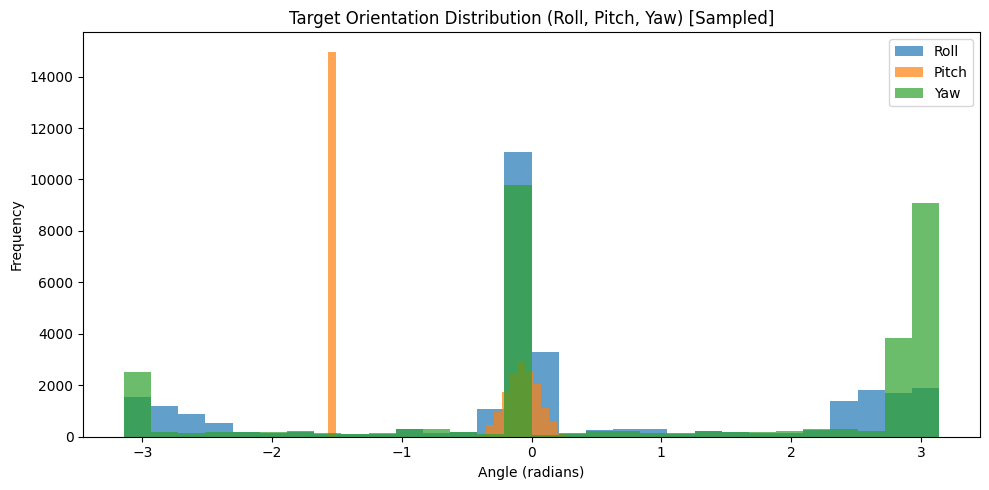

In [8]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Sample a portion of the training set for target orientation statistics
target_orientations = []
sample_portion = 0.1  # Use 10% of the batches
max_batches = int(len(train_loader) * sample_portion)
max_batches = max(1, max_batches)  # At least 1 batch

for i, batch in enumerate(train_loader):
    target_pose = batch["target_pose"]
    if target_pose.ndim == 2 and target_pose.shape[1] >= 7:
        # Assume last 4 values are quaternion (x, y, z, w)
        quats = target_pose[:, 3:7].cpu().numpy()
        # Convert quaternion (x, y, z, w) to (w, x, y, z) if needed
        # If your library expects (w, x, y, z), use: quats = quats[:, [3, 0, 1, 2]]
        quats = quats[:, [3, 0, 1, 2]] # Convert to (w, x, y, z) order
        r = R.from_quat(quats)  # (x, y, z, w) order for scipy
        eulers = r.as_euler('xyz', degrees=False)  # roll, pitch, yaw
        target_orientations.append(eulers)
    if i + 1 >= max_batches:
        break

target_orientations = np.concatenate(target_orientations, axis=0)

print("Target orientation statistics (roll, pitch, yaw) [radians]:")
print(f"Shape: {target_orientations.shape}")
print(f"Min: {np.min(target_orientations, axis=0)}")
print(f"Max: {np.max(target_orientations, axis=0)}")
print(f"Mean: {np.mean(target_orientations, axis=0)}")
print(f"Std: {np.std(target_orientations, axis=0)}")
print(f"Range: {np.ptp(target_orientations, axis=0)}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(target_orientations[:, 0], bins=30, alpha=0.7, label='Roll')
plt.hist(target_orientations[:, 1], bins=30, alpha=0.7, label='Pitch')
plt.hist(target_orientations[:, 2], bins=30, alpha=0.7, label='Yaw')
plt.xlabel("Angle (radians)")
plt.ylabel("Frequency")
plt.title("Target Orientation Distribution (Roll, Pitch, Yaw) [Sampled]")
plt.legend()
plt.tight_layout()
plt.show()

Analyzing pretrain_data/curobo/train/train.hdf5...
HDF5 file structure:
  cuboid_centers (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_dims (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_quaternions (Dataset)
    Shape: (6000, 7, 4), Type: float32
  cylinder_centers (Dataset)
    Shape: (6000, 0, 3), Type: float32
  cylinder_heights (Dataset)
    Shape: (6000, 0, 1), Type: float32
  cylinder_quaternions (Dataset)
    Shape: (6000, 0, 4), Type: float32
  cylinder_radii (Dataset)
    Shape: (6000, 0, 1), Type: float32
  global_solutions (Dataset)
    Shape: (6000, 50, 7), Type: float32
  Found global_solutions at global_solutions with shape (6000, 50, 7)
Analyzing pretrain_data/ompl/train/train.hdf5...
HDF5 file structure:
  cuboid_centers (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_dims (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_quaternions (Dataset)
    Shape: (6000, 7, 4), Type: float32
  cylinder_centers (Dataset)
    Shape: (6000, 

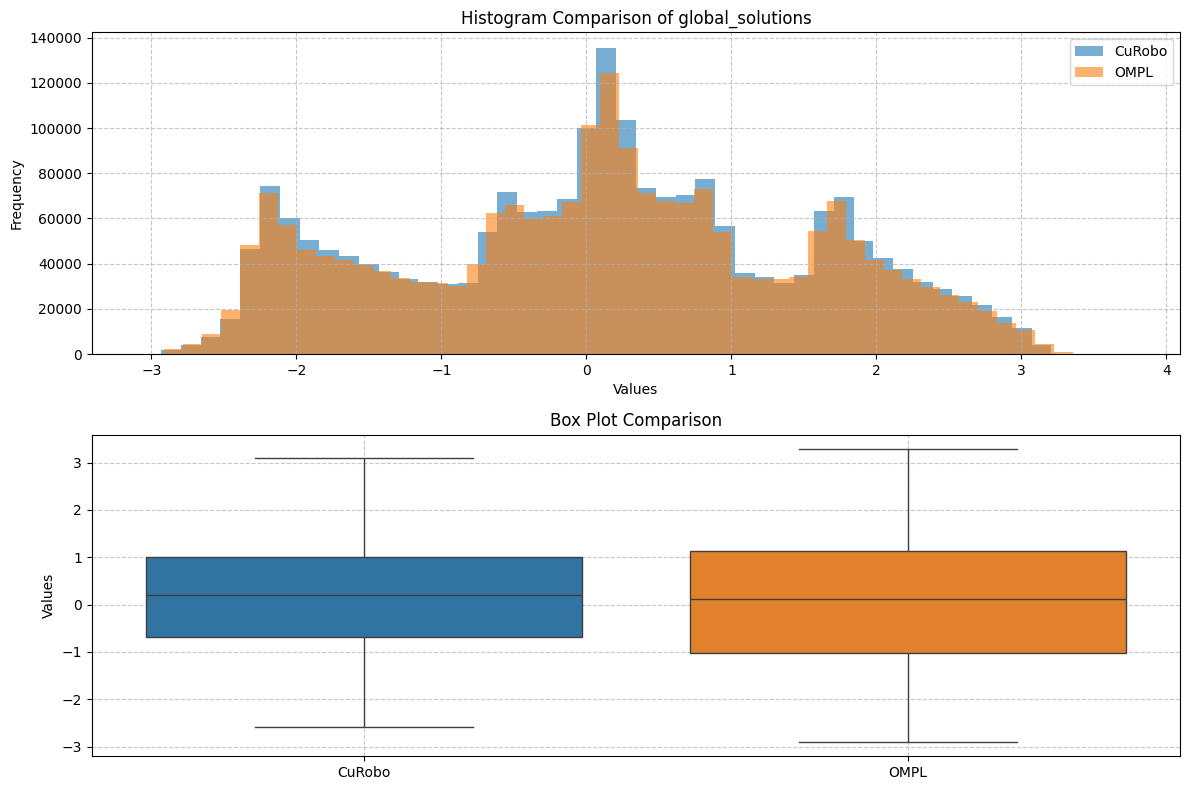

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

def analyze_global_solutions(file_path):
    """Extract and analyze global_solutions from an HDF5 file"""
    print(f"Analyzing {file_path}...")
    solutions = []
    
    try:
        with h5py.File(file_path, 'r') as f:
            # Print the structure of the file to understand its contents
            print("HDF5 file structure:")
            def print_structure(name, obj):
                print(f"  {name} {'(Group)' if isinstance(obj, h5py.Group) else '(Dataset)'}")
                if isinstance(obj, h5py.Dataset):
                    print(f"    Shape: {obj.shape}, Type: {obj.dtype}")
            
            f.visititems(print_structure)
            
            # Try common paths where global_solutions might be stored
            possible_paths = ['global_solutions', 'data/global_solutions', 'solutions/global']
            
            for path in possible_paths:
                if path in f:
                    data = f[path][:]
                    solutions = data
                    print(f"  Found global_solutions at {path} with shape {data.shape}")
                    break
            
            # If not found in common paths, search for datasets with similar names
            if not len(solutions):
                for name, obj in f.items():
                    if isinstance(obj, h5py.Dataset) and 'solution' in name.lower():
                        data = obj[:]
                        solutions = data
                        print(f"  Found solutions at {name} with shape {data.shape}")
                        break
    
    except Exception as e:
        print(f"  Error processing file: {e}")
    
    return solutions

def compare_distributions():
    """Compare global_solutions distributions between CuRobo and OMPL"""
    # Define file paths
    curobo_file = "pretrain_data/curobo/train/train.hdf5"
    ompl_file = "pretrain_data/ompl/train/train.hdf5"
    
    # Check if files exist
    if not os.path.exists(curobo_file):
        print(f"File not found: {curobo_file}")
        return
    
    if not os.path.exists(ompl_file):
        print(f"File not found: {ompl_file}")
        return
    
    # Load and analyze data
    curobo_solutions = analyze_global_solutions(curobo_file)
    ompl_solutions = analyze_global_solutions(ompl_file)
    
    if len(curobo_solutions) == 0:
        print("No global_solutions found in CuRobo data")
        return
    
    if len(ompl_solutions) == 0:
        print("No global_solutions found in OMPL data")
        return
    
    # Flatten solutions for analysis if needed
    if isinstance(curobo_solutions, np.ndarray) and curobo_solutions.ndim > 1:
        curobo_values = curobo_solutions.flatten()
    else:
        curobo_values = curobo_solutions
        
    if isinstance(ompl_solutions, np.ndarray) and ompl_solutions.ndim > 1:
        ompl_values = ompl_solutions.flatten()
    else:
        ompl_values = ompl_solutions
    
    # Calculate statistics
    stats = {
        'Method': ['CuRobo', 'OMPL'],
        'Min': [np.min(curobo_values), np.min(ompl_values)],
        'Max': [np.max(curobo_values), np.max(ompl_values)],
        'Mean': [np.mean(curobo_values), np.mean(ompl_values)],
        'Median': [np.median(curobo_values), np.median(ompl_values)],
        'Std Dev': [np.std(curobo_values), np.std(ompl_values)],
        'Count': [len(curobo_values), len(ompl_values)]
    }
    
    # Display statistics
    stats_df = pd.DataFrame(stats).set_index('Method')
    print("\nStatistics Comparison:")
    print(stats_df)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Histogram comparison
    plt.subplot(2, 1, 1)
    plt.hist(curobo_values, bins=50, alpha=0.6, label='CuRobo')
    plt.hist(ompl_values, bins=50, alpha=0.6, label='OMPL')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram Comparison of global_solutions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Box plot comparison
    plt.subplot(2, 1, 2)
    data = {
        'CuRobo': curobo_values[:min(len(curobo_values), 10000)],
        'OMPL': ompl_values[:min(len(ompl_values), 10000)]
    }
    sns.boxplot(data=pd.DataFrame(data))
    plt.title('Box Plot Comparison')
    plt.ylabel('Values')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('global_solutions_comparison.png')
    print("\nVisualization saved as 'global_solutions_comparison.png'")

if __name__ == "__main__":
    compare_distributions()

In [1]:
# Import necessary libraries
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from models.policynet import PolicyNet, TrainingPolicyNet
from data_loader import PointCloudInstanceDataset, DatasetType
from robofin.pointcloud.torch import FrankaSampler
import utils

/home/zippingsugar/mambaforge/envs/pointnet2/lib/python3.8/site-packages/spconv/pytorch/functional.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  _TORCH_CUSTOM_FWD = amp.custom_fwd(cast_inputs=torch.float16)
/home/zippingsugar/mambaforge/envs/pointnet2/lib/python3.8/site-packages/spconv/pytorch/functional.py:97: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/zippingsugar/mambaforge/envs/pointnet2/lib/python3.8/site-packages/spconv/pytorch/functional.py:163: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/home/zippingsugar/mambaforge/envs/pointnet2/lib/python3.8/site-packages/spconv/pytorch/functional.py:243: FutureWarning: `torch.cud

In [2]:
# Configuration
MODEL_CHECKPOINT = "./checkpoints/sxp9r1ag/epoch-epoch=49-end.ckpt"  # Update with your checkpoint path
DATA_DIR = "./pretrain_data/ompl_table_6k"  # Update with your data directory
TRAJECTORY_KEY = "global_solutions"
NUM_ROBOT_POINTS = 2048
NUM_OBSTACLE_POINTS = 4096
BATCH_SIZE = 4  # Small batch for visualization

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load model
model = TrainingPolicyNet.load_from_checkpoint(
    MODEL_CHECKPOINT,
    pc_latent_dim=2048,
    num_robot_points=NUM_ROBOT_POINTS,
    bc_loss_weight=1.0,
    collision_loss_weight=0.1
)
model.to(device)
model.eval()

# Initialize samplers if needed
if model.fk_sampler is None:
    model.fk_sampler = FrankaSampler(device, use_cache=True)

In [4]:
# Load data
dataset = PointCloudInstanceDataset(
    Path(DATA_DIR),
    TRAJECTORY_KEY,
    NUM_ROBOT_POINTS,
    NUM_OBSTACLE_POINTS,
    DatasetType.TRAIN,  # Using training data for testing
    random_scale=0.0    # No randomization for testing
)

# Create a small dataloader for testing
test_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Databases found: [PosixPath('pretrain_data/ompl/train/train.hdf5')]


In [3]:
# Calculate statistics for the supervision signal
from data_loader import DataModule

# Set up your DataModule (adjust parameters as needed)
data_module = DataModule(
    data_dir= DATA_DIR,  # <-- change this to your data path
    trajectory_key=TRAJECTORY_KEY,  # <-- change this to your key
    num_robot_points=128,
    num_obstacle_points=128,
    random_scale=0,
    batch_size=32,
)
data_module.setup("fit")

# Collect all supervision signals from the training set
all_supervision = []
for i in range(len(data_module.data_train)):
    item = data_module.data_train[i]
    all_supervision.append(item["supervision"])

all_supervision = torch.stack(all_supervision)

print("Supervision statistics:")
print(f"Shape: {all_supervision.shape}")
print(f"Min: {all_supervision.min(dim=0).values}")
print(f"Max: {all_supervision.max(dim=0).values}")
print(f"Mean: {all_supervision.mean(dim=0)}")
print(f"Std: {all_supervision.std(dim=0)}")

Databases found: [PosixPath('pretrain_data/ompl_table_6k/train/train.hdf5')]
Databases found: [PosixPath('pretrain_data/ompl_table_6k/val/val.hdf5')]
Supervision statistics:
Shape: torch.Size([300000, 7])
Min: tensor([-0.1179, -0.1002, -0.1156, -0.0885, -0.1091, -0.0917, -0.1403])
Max: tensor([0.1286, 0.0944, 0.1131, 0.0925, 0.1325, 0.0998, 0.1425])
Mean: tensor([ 1.2397e-04, -5.4360e-05,  1.1922e-05, -4.2453e-05, -2.0353e-05,
        -8.0843e-05, -5.4258e-05])
Std: tensor([0.0290, 0.0331, 0.0281, 0.0173, 0.0224, 0.0172, 0.0574])


In [5]:
# Get a batch of data
batch = next(iter(test_dataloader))

# Move data to device
for key in batch:
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].to(device)

In [13]:
# Run model prediction
with torch.no_grad():
    # Extract inputs
    xyz = batch["xyz"]
    q = batch["configuration"]
    target = batch["target_configuration"]
    supervision = batch["supervision"]
    
    # Forward pass
    model_output = model(xyz, q, target)
    prediction = q + model_output
    ground_truth = q + supervision
    
    # Calculate losses
    bc_loss = torch.nn.MSELoss()(model_output, supervision)
    
    # Calculate collision loss
    input_pc = model.fk_sampler.sample(
        prediction, 
        model.num_robot_points
    )
    
    collision_loss = utils.collision_loss(
        input_pc,
        batch["cuboid_centers"],
        batch["cuboid_dims"],
        batch["cuboid_quats"],
        batch["cylinder_centers"],
        batch["cylinder_radii"],
        batch["cylinder_heights"],
        batch["cylinder_quats"],
    )
    
    # Total loss
    total_loss = model.bc_loss_weight * bc_loss + model.collision_loss_weight * collision_loss
    
    print(f"BC Loss: {bc_loss.item():.6f}")
    print(f"Collision Loss: {collision_loss.item():.6f}")
    print(f"Total Loss: {total_loss.item():.6f}")
    
    # Unnormalize predictions for better visualization/comparison
    # q_unnorm = utils.unnormalize_franka_joints(q)
    q_unnorm = q
    pred_unnorm = prediction
    ground_truth_unnorm = ground_truth
    supervision_unnorm = supervision
    model_output_unnorm = model_output

BC Loss: 0.000274
Collision Loss: 0.000030
Total Loss: 0.000277


In [4]:
# Compare predictions with ground truth for the first item in batch
sample_idx = 0

print("\nSample comparison (joint angles in radians):")
print(f"\nInput configuration:")
print(q_unnorm[sample_idx].cpu().numpy())

print(f"\nModel prediction:")
print(pred_unnorm[sample_idx].cpu().numpy())

print(f"\nGround truth:")
print(ground_truth_unnorm[sample_idx].cpu().numpy())

print(f"\nModel output:")
print(model_output_unnorm[sample_idx].cpu().numpy())

print(f"\nsupervision:")
print(supervision_unnorm[sample_idx].cpu().numpy())

# Calculate difference
diff = torch.abs(pred_unnorm[sample_idx] - ground_truth_unnorm[sample_idx])
print(f"\nAbsolute difference per joint:")
print(diff.cpu().numpy())
print(f"Mean absolute error: {diff.mean().item():.6f} radians")


Sample comparison (joint angles in radians):

Input configuration:


NameError: name 'q_unnorm' is not defined

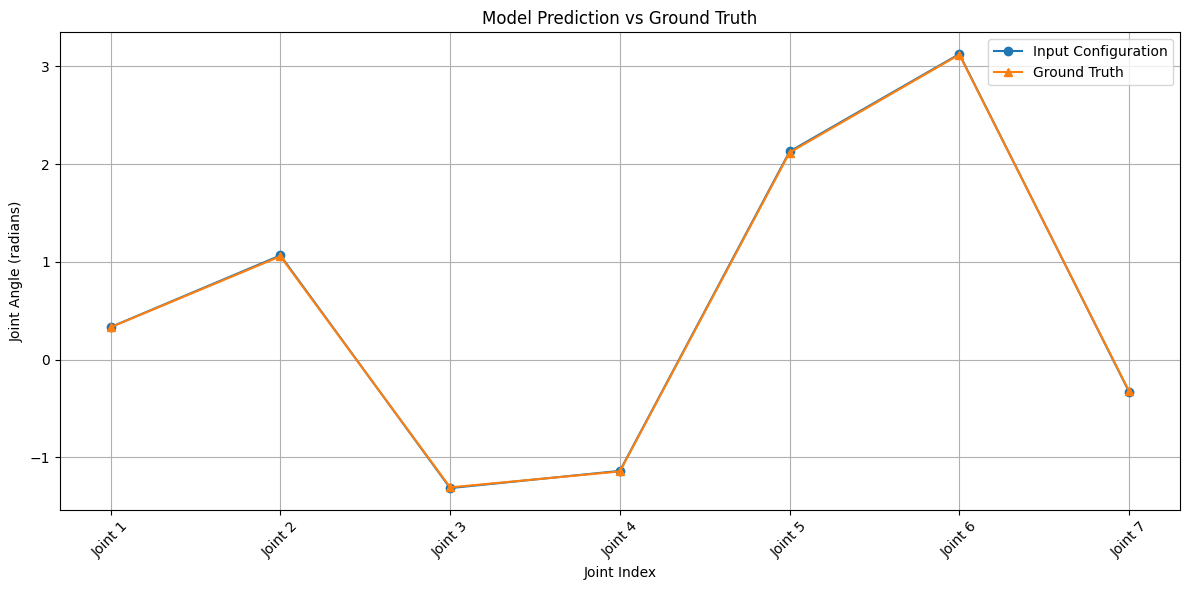

In [20]:
# Visualize prediction vs ground truth
joint_indices = np.arange(7)
joint_names = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5", "Joint 6", "Joint 7"]

plt.figure(figsize=(12, 6))

# Plot input configuration
plt.plot(joint_indices, q_unnorm[sample_idx].cpu().numpy(), 'o-', label='Input Configuration')

# # Plot prediction
# plt.plot(joint_indices, pred_unnorm[sample_idx].cpu().numpy(), 's-', label='Model Prediction')

# Plot ground truth
plt.plot(joint_indices, ground_truth_unnorm[sample_idx].cpu().numpy(), '^-', label='Ground Truth')

plt.xlabel('Joint Index')
plt.ylabel('Joint Angle (radians)')
plt.title('Model Prediction vs Ground Truth')
plt.xticks(joint_indices, joint_names, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np

def convert_robotB_to_robotA(pose_B):
    """
    Converts Robot B's pose (4x4 matrix) to match Robot A's convention
    by removing the additional tool transformation.
    
    Args:
        pose_B: 4x4 transformation matrix from Robot B
    
    Returns:
        T_A: 4x4 transformation matrix in Robot A's convention
    """
    # Extract rotation matrix and translation vector
    R_B = pose_B[:3, :3]
    p_B = pose_B[:3, 3]
    
    # Compute corrected rotation: 
    # Negate first two columns (180° z-rotation compensation)
    R_A = R_B.copy()
    R_A[:, 0] = -R_A[:, 0]  # Negate x-axis
    R_A[:, 1] = -R_A[:, 1]  # Negate y-axis
    
    # Compute corrected translation:
    # Remove tool offset along z-axis
    w = R_B[:, 2]  # Z-axis direction vector
    p_A = p_B - 0.1 * w
    
    # Build corrected transformation matrix
    T_A = np.eye(4)
    T_A[:3, :3] = R_A
    T_A[:3, 3] = p_A
    
    return T_A

In [11]:
# Define a list of 6 different q values
q_list = [
    [0.0, -0.5, 0.0, -2.0, 0.0, 1.5, 0.8],
    [0.1, -0.4, 0.1, -1.9, 0.1, 1.4, 0.7],
    [0.2, -0.3, 0.2, -1.8, 0.2, 1.3, 0.6],
    [0.3, -0.2, 0.3, -1.7, 0.3, 1.2, 0.5],
    [0.4, -0.1, 0.4, -1.6, 0.4, 1.1, 0.4],
    [0.5, 0.0, 0.5, -1.5, 0.5, 1.0, 0.3],
]

import numpy as np
from robofin.robots import FrankaRealRobot
from pyquaternion import Quaternion

# Assume convert_robotB_to_robotA is already defined in the notebook

# Set the finger joint value (not used in FrankaRealRobot.fk, but shown for completeness)
panda_finger_joint = 0.04

for idx, q in enumerate(q_list):
    pose = FrankaRealRobot.fk(q)
    pose_B = pose.matrix
    pose_A = convert_robotB_to_robotA(pose_B)
    print(f"q[{idx}]: {q}")
    print(f"Pose: xyz (Robot A): {pose_A[:3, 3]}")
    print(f"  Pose matrix (Robot A):\n{pose_A}")

q[0]: [0.0, -0.5, 0.0, -2.0, 0.0, 1.5, 0.8]
Pose: xyz (Robot A): [ 3.86104347e-01 -2.15766310e-35  6.52325118e-01]
  Pose matrix (Robot A):
[[ 9.99893395e-01 -1.46013177e-02 -4.16333634e-17  3.86104347e-01]
 [-1.46013177e-02 -9.99893395e-01  3.71575191e-33 -2.15766310e-35]
 [-4.16289251e-17  6.07901967e-19 -1.00000000e+00  6.52325118e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
q[1]: [0.1, -0.4, 0.1, -1.9, 0.1, 1.4, 0.7]
Pose: xyz (Robot A): [0.39538903 0.10172547 0.64955046]
  Pose matrix (Robot A):
[[ 0.95358293  0.27972537 -0.1115048   0.39538903]
 [ 0.28548701 -0.95757852  0.0392497   0.10172547]
 [-0.09579546 -0.06926102 -0.99298849  0.64955046]
 [ 0.          0.          0.          1.        ]]
q[2]: [0.2, -0.3, 0.2, -1.8, 0.2, 1.3, 0.6]
Pose: xyz (Robot A): [0.38017802 0.20392593 0.64445866]
  Pose matrix (Robot A):
[[ 0.80180358  0.54670169 -0.24130536  0.38017802]
 [ 0.57220437 -0.81880789  0.04621467  0.20392593]
 [-0.17231709 -0.17513107 -0.96934

In [ ]:
# Use pybullet to show the robot of a certain configuration
import numpy as np
import time
import meshcat
import urchin

from robofin.robots import FrankaRobot
from robofin.bullet import BulletController


q = np.array([1.66637063, 0.94623581, 1.29493979, -2.6301331, 1.54359708, 0.54974192, -0.34566782])

# Example configuration (7-DOF, radians)
config = np.array([q[0], q[1], q[2], q[3], q[4], q[5], q[6], 0.4])  # Last value is for the finger joint

# Setup simulation
sim = BulletController(hz=12, substeps=20, gui=True)
franka = sim.load_robot(FrankaRobot)

# Setup meshcat visualizer
viz = meshcat.Visualizer()
print(f"MeshCat URL: {viz.url()}")

# Load URDF for meshcat visualization
urdf = urchin.URDF.load(FrankaRobot.urdf)
for idx, (k, v) in enumerate(urdf.visual_trimesh_fk(config).items()):
    viz[f"robot/{idx}"].set_object(
        meshcat.geometry.TriangularMeshGeometry(k.vertices, k.faces),
        meshcat.geometry.MeshLambertMaterial(color=0xEEDD22, wireframe=False),
    )
    viz[f"robot/{idx}"].set_transform(v)

# Move robot in simulation
franka.marionette(config)
time.sleep(0.5)
for _ in range(50):
    sim.step()
    sim_config, _ = franka.get_joint_states()
    for idx, (k, v) in enumerate(urdf.visual_trimesh_fk(sim_config[:8]).items()):
        viz[f"robot/{idx}"].set_transform(v)
    time.sleep(0.05)

pybullet build time: Jan 29 2025 23:19:57


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3080 Laptop GPU/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 570.133.20
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 570.133.20
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3080 Laptop GPU/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
MeshCat URL: h

Exception: Length of input state should be either 7 or 9

: 

In [1]:
# Extract the pretrained policy
import torch
from models.policynet import PolicyNet
model_path = "./checkpoints/n15mdb71/last.ckpt"  # Update with your checkpoint path

model = PolicyNet.load_from_checkpoint(model_path)
mlp = model.policy

# Save the MLP's state_dict
torch.save(mlp.state_dict(), "mlp_policy.pth")
print("MLP weights saved to mlp_policy.pth")

MLP weights saved to mlp_policy.pth


Overall minimum distance: tensor([[0.1625, 0.2458, 0.2546, 0.2156, 0.2960, 0.3081, 0.1863]],
       device='cuda:0') m

Collision Distance Results:
Overall minimum distance: 0.1625 m
panda_link1:
  Min distance: 0.1625 m
  Closest obstacle: cuboid
panda_link2:
  Min distance: 0.2458 m
  Closest obstacle: cuboid
panda_link3:
  Min distance: 0.2546 m
  Closest obstacle: cuboid
panda_link4:
  Min distance: 0.2156 m
  Closest obstacle: cuboid
panda_link5:
  Min distance: 0.2960 m
  Closest obstacle: cuboid
panda_link6:
  Min distance: 0.3081 m
  Closest obstacle: cylinder
panda_hand:
  Min distance: 0.1863 m
  Closest obstacle: cylinder


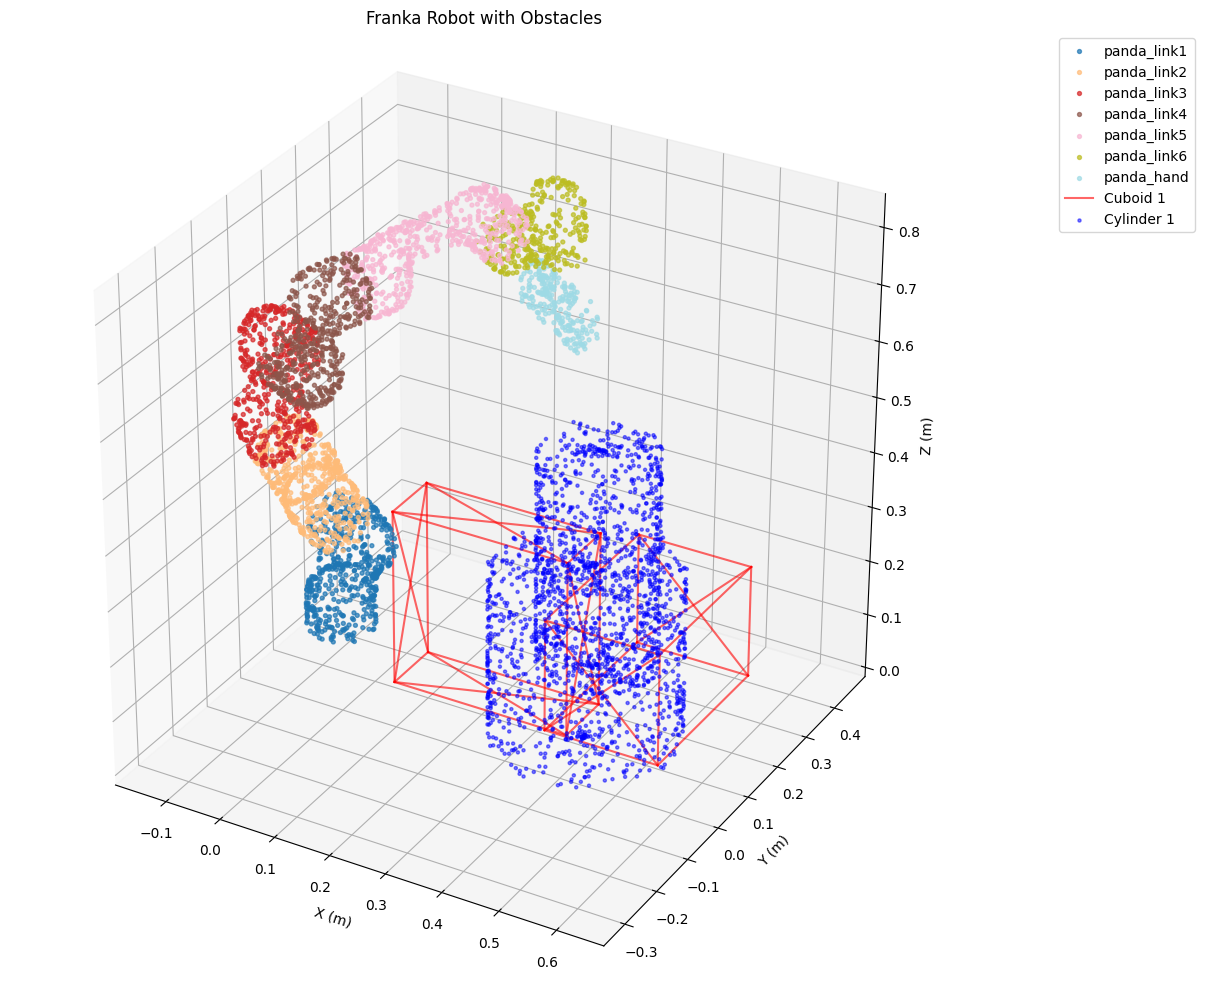

In [6]:
import torch
from utils import FrankaSampler, links_obs_dist
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from geometrout.primitive import Sphere, Cuboid, Cylinder


def visualize_robot_with_obstacles(per_link_pcs, obstacles):
    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot robot links
    colors = plt.cm.tab20(np.linspace(0, 1, len(per_link_pcs)))
    for (link_name, pc), color in zip(per_link_pcs.items(), colors):
        if pc.ndim == 3:
            pc = pc[0]  # Take first configuration if batch
        
        x, y, z = pc[:, 0].cpu().numpy(), pc[:, 1].cpu().numpy(), pc[:, 2].cpu().numpy()
        ax.scatter(x, y, z, s=8, alpha=0.7, color=color, label=link_name)
    
    # Plot obstacles
    # Cuboids
    for i, cuboid in enumerate(obstacles['cuboids']):
        # Get cuboid corners
        corners = cuboid.corners
        
        # Plot edges of the cuboid
        from itertools import combinations
        for s, e in combinations(corners, 2):
            if np.sum((s-e)**2) < 0.1 + 1e-6:  # Only plot adjacent edges
                ax.plot3D(*zip(s, e), color='red', alpha=0.6, 
                         label=f'Cuboid {i+1}' if i == 0 else "")
    
    # Cylinders
    for i, cylinder in enumerate(obstacles['cylinders']):
        # Sample points on the cylinder surface
        points = cylinder.sample_surface(1000)
        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        ax.scatter(x, y, z, s=5, alpha=0.5, color='blue', 
                   label=f'Cylinder {i+1}' if i == 0 else "")
    
    # Configure plot
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Franka Robot with Obstacles')
    
    # Equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    # Set equal limits based on all data
    all_points = np.concatenate([pc[0].cpu().numpy() for pc in per_link_pcs.values()], axis=0)
    
    # Add obstacle points to determine limits
    for cuboid in obstacles['cuboids']:
        all_points = np.vstack([all_points, cuboid.corners])
    for cylinder in obstacles['cylinders']:
        points = cylinder.sample_surface(10)
        all_points = np.vstack([all_points, points])
    
    max_range = np.array([all_points[:,0].max()-all_points[:,0].min(), 
                         all_points[:,1].max()-all_points[:,1].min(), 
                         all_points[:,2].max()-all_points[:,2].min()]).max() / 2.0
    
    mid_x = (all_points[:,0].max()+all_points[:,0].min()) * 0.5
    mid_y = (all_points[:,1].max()+all_points[:,1].min()) * 0.5
    mid_z = (all_points[:,2].max()+all_points[:,2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


def visualize_robot_with_collision_spheres(per_link_pcs, spheres=None):
    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot robot links
    colors = plt.cm.tab20(np.linspace(0, 1, len(per_link_pcs)))
    for (link_name, pc), color in zip(per_link_pcs.items(), colors):
        if pc.ndim == 3:
            pc = pc[0]  # Take first configuration if batch
        
        x, y, z = pc[:, 0].cpu().numpy(), pc[:, 1].cpu().numpy(), pc[:, 2].cpu().numpy()
        ax.scatter(x, y, z, s=8, alpha=0.7, color=color, label=link_name)
    
    # Plot collision spheres if provided
    if spheres:
        for sphere in spheres:
            # Create sphere surface points
            u = np.linspace(0, 2 * np.pi, 20)
            v = np.linspace(0, np.pi, 20)
            x = sphere.center[0] + sphere.radius * np.outer(np.cos(u), np.sin(v)).flatten()
            y = sphere.center[1] + sphere.radius * np.outer(np.sin(u), np.sin(v)).flatten()
            z = sphere.center[2] + sphere.radius * np.outer(np.ones(np.size(u)), np.cos(v)).flatten()
            
            ax.scatter(x, y, z, s=1, alpha=0.3, color='red', label='Collision Sphere' if not spheres[1:] else "")
    
    # Configure plot
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Franka Robot with Collision Spheres')
    
    # Equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    # Set equal limits based on all data
    all_points = np.concatenate([pc[0].cpu().numpy() for pc in per_link_pcs.values()], axis=0)
    max_range = np.array([all_points[:,0].max()-all_points[:,0].min(), 
                         all_points[:,1].max()-all_points[:,1].min(), 
                         all_points[:,2].max()-all_points[:,2].min()]).max() / 2.0
    
    mid_x = (all_points[:,0].max()+all_points[:,0].min()) * 0.5
    mid_y = (all_points[:,1].max()+all_points[:,1].min()) * 0.5
    mid_z = (all_points[:,2].max()+all_points[:,2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sampler = FrankaSampler(device, use_cache=True)

# Configuration
config = torch.tensor([1.0, -0.5, 0.0, -2.0, 0.0, 1.5, 0.8, 0.04], device=device).unsqueeze(0)
per_link_pcs = sampler.sample_per_link(config)


import numpy as np
from geometrout.primitive import Cuboid, Cylinder

# First define all obstacle parameters as arrays
cuboid_centers = np.array([
    [0.4, -0.2, 0.4],    # Cuboid 1
    [0.5, 0.1, 0.2]       # Cuboid 2
])

cuboid_dims = np.array([
    [0.3, 0.1, 0.3],      # Cuboid 1 dimensions
    [0.3, 0.2, 0.2]       # Cuboid 2 dimensions
])

cuboid_quaternions = np.array([
    [1, 0, 0, 0],         # Cuboid 1 orientation (identity)
    [0.707, 0, 0, 0.707]  # Cuboid 2 orientation (90° about x-axis)
])

cylinder_centers = np.array([
    [0.3, 0.3, 0.2],      # Cylinder 1
    [0.5, -0.1, 0.3]      # Cylinder 2
])

cylinder_radii = np.array([0.1, 0.15])    # Radii for cylinders
cylinder_heights = np.array([0.4, 0.3])   # Heights for cylinders
cylinder_quaternions = np.array([
    [1, 0, 0, 0],         # Cylinder 1 orientation
    [0.924, 0, 0, 0.383]  # Cylinder 2 orientation (45° about x-axis)
])

# Create obstacle objects from the arrays
obstacles = {
    'cuboids': [
        Cuboid(center=center, dims=dims, quaternion=quat)
        for center, dims, quat in zip(cuboid_centers, cuboid_dims, cuboid_quaternions)
    ],
    'cylinders': [
        Cylinder(center=center, radius=radius, height=height, quaternion=quat)
        for center, radius, height, quat in zip(
            cylinder_centers, cylinder_radii, cylinder_heights, cylinder_quaternions
        )
    ]
}

# Compute distances
# Convert inputs to PyTorch tensors on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert obstacle parameters to tensors
cuboid_centers_t = torch.from_numpy(cuboid_centers).float().to(device).unsqueeze(0)  # [1, M1, 3]
cuboid_dims_t = torch.from_numpy(cuboid_dims).float().to(device).unsqueeze(0)  # [1, M1, 3]
cuboid_quats_t = torch.from_numpy(cuboid_quaternions).float().to(device).unsqueeze(0)  # [1, M1, 4]

cylinder_centers_t = torch.from_numpy(cylinder_centers).float().to(device).unsqueeze(0)  # [1, M2, 3]
cylinder_radii_t = torch.from_numpy(cylinder_radii).float().to(device).unsqueeze(0).unsqueeze(-1)  # [1, M2, 1]
cylinder_heights_t = torch.from_numpy(cylinder_heights).float().to(device).unsqueeze(0).unsqueeze(-1)  # [1, M2, 1]
cylinder_quats_t = torch.from_numpy(cylinder_quaternions).float().to(device).unsqueeze(0)  # [1, M2, 4]

# Compute distances
distances = links_obs_dist(
    per_link_pcs,
    cuboid_centers_t,
    cuboid_dims_t,
    cuboid_quats_t,
    cylinder_centers_t,
    cylinder_radii_t,
    cylinder_heights_t,
    cylinder_quats_t,
    debug=True
)

min_dist = links_obs_dist(
    per_link_pcs,
    cuboid_centers_t,
    cuboid_dims_t,
    cuboid_quats_t,
    cylinder_centers_t,
    cylinder_radii_t,
    cylinder_heights_t,
    cylinder_quats_t,
    debug=False
)

print(f"Overall minimum distance: {min_dist} m")

# Print results (convert tensors back to numpy for printing)
print("\nCollision Distance Results:")
print(f"Overall minimum distance: {distances['min_distance'].item():.4f} m")

for link, data in distances['per_link'].items():
    print(f"{link}:")
    print(f"  Min distance: {data['min_distance'].item():.4f} m")
    print(f"  Closest obstacle: {data['closest_obstacle_type']}")

# Visualize only robot links 
# visualize_robot_with_collision_spheres(per_link_pcs)

# Example usage with your existing setup
visualize_robot_with_obstacles(per_link_pcs, obstacles)